In [103]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
import random
from sklearn.metrics import confusion_matrix
import seaborn as sns

from model import LDM

In [110]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.distributions import Normal
import pandas as pd
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

class LDMP(torch.nn.Module):
    def __init__(self, Aij, embedding_dim, device, n_epochs, lr, seed=None):
        super(LDMP, self).__init__()
        self.Aij = Aij.to(device)
        self.device = device
        self.n_drugs, self.n_effects = Aij.shape
        self.n_ordinal_classes = Aij.max().int().item() +1

        #set seed
        self.seed = seed
        self.__set_seed(seed)

        #Variables for the learning process
        self.n_epochs = n_epochs
        self.lr = lr

        #parameters to be learned (latent representations)
        self.beta = nn.Parameter(torch.randn(self.n_effects, device=device))
        self.w = torch.nn.Parameter(torch.randn(self.n_drugs, embedding_dim, device=device))  # Latent embeddings for drugs
        self.v = torch.nn.Parameter(torch.randn(self.n_effects, embedding_dim, device=device))  # Latent embeddings for side effects

        # Parameters to be learned (thresholds)
        self.beta_thilde = nn.Parameter(torch.randn(self.n_ordinal_classes, device=device))
        self.a = nn.Parameter(torch.rand(1, device=device))
        self.b = nn.Parameter(torch.rand(1, device=device))
    
    def __set_seed(self, seed):
        if seed is not None:
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed_all(seed)

    def get_embeddings(self):
        return self.w, self.v
    

    def get_thresholds(self):
        # Ensure thresholds remain positive and increasing
        deltas = torch.softmax(self.beta_thilde, dim = 0)  # Ensure positive increments
        thresholds = torch.cumsum(deltas, dim=0)* self.a - self.b
        return torch.cat([torch.tensor([-float("inf")], device=self.device), thresholds, torch.tensor([float("inf")], device=self.device)])
    
    def probit(self):
        # #n_ordinal_classes = len(self.thresholds) - 1
        # #n_drugs, n_effects = self.Aij.shape
        normal_dist = Normal(0, 1) # Noise contaminated by normal distribution
        probit_matrix = torch.zeros((self.n_ordinal_classes, self.n_drugs, self.n_effects), device=self.device)
        thresholds = self.get_thresholds()
    
        #Linear term (\beta^T x_{i,j})
        linear_term = torch.matmul(self.Aij, self.beta.unsqueeze(1))

        # Distance term -|w_i - v_j|
        dist = -torch.norm(self.w.unsqueeze(1) - self.v.unsqueeze(0), dim=2)

        # Latent variable \beta^T x_{i,j} + \alpha(u_i - u_j)
        latent_var = linear_term + dist
        
        for y in range(self.n_ordinal_classes):
            z1 = latent_var - thresholds[y]
            z2 = latent_var - thresholds[y+1]
            probit_matrix[y, :, :] = normal_dist.cdf(z1) - normal_dist.cdf(z2)
        return probit_matrix

    
    def predict_categories(self):
        probit_matrix = self.probit()  # Call probit to get probabilities
        return torch.argmax(probit_matrix, dim=0), probit_matrix
    
    def ordinal_cross_entropy_loss(self):
    # Compute the predicted probabilities using the probit function
        probit_matrix = self.probit() 

        # Initialize loss variable
        loss = 0.0

        # Convert Aij to a one-hot encoded tensor
        one_hot_target = torch.zeros(self.n_drugs, self.n_effects, self.n_ordinal_classes, device=self.device)
        one_hot_target.scatter_(-1, self.Aij.unsqueeze(-1).long(), 1)  # One-hot encoding

        # Compute the log-likelihood loss efficiently
        prob = probit_matrix  # Shape: (n_ordinal_classes, n_drugs, n_effects)
        # loss = -torch.sum(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        loss = -torch.mean(torch.log(torch.sum(prob * one_hot_target.permute(2, 0, 1), dim=0) + 1e-8))
        return loss

    def train(self, print=False):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        #final_loss = None  # Store the last loss
        epoch_losses = []

        for epoch in range(self.n_epochs):
            optimizer.zero_grad()  # Reset gradients
            loss = self.ordinal_cross_entropy_loss()  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters
            
            #final_loss = loss.item()  # Store latest loss value
            epoch_losses.append(loss.item())
            if print: 
                if epoch % 10 == 0:  # Print every 10 epochs
                    print(f"Epoch {epoch}/{self.n_epochs}, Loss: {loss.item():.4f}")

        return epoch_losses #,final_loss

    def get_params(self):
        return self.beta, self.w.detach().cpu().numpy(), self.v.detach().cpu().numpy(), self.beta_thilde.detach().cpu().numpy()
        
    def save_embeddings():
        raise NotImplementedError

In [8]:
def create_holdout(Aij, holdout_ratio=0.1, seed=42):
    Aij_train = Aij.clone()
    if seed is not None:
        random.seed(seed)

    Aij_np = Aij.cpu().numpy()
    pos_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j] > 0]
    neg_cases = [(i,j) for i in range(Aij_np.shape[0]) for j in range(Aij_np.shape[1]) if Aij_np[i,j]==0]

    # select holdtout cases randomly
    n_holdout_pos = int(len(pos_cases)*holdout_ratio)
    n_holdout_neg = int(len(neg_cases)*holdout_ratio)

    holdout_pos = random.sample(pos_cases, n_holdout_pos)
    holdout_neg = random.sample(neg_cases, n_holdout_neg)

    holdouts = holdout_pos + holdout_neg
    random.shuffle(holdouts)
    for i, j in holdouts:
        Aij_train[i,j]=0.0
    return Aij_train, holdouts

In [107]:
class ModelEvaluate:
    def __init__(self, model, Aij_true, test_indices=None):
        self.model = model
        self.Aij_true = Aij_true
        self.test_indices = test_indices

    def _get_predictions(self):
        self.model.eval_mode = True
        with torch.no_grad():
            preds, _ = self.model.predict_categories()
            preds_np = preds.cpu().numpy()
        return preds_np
    
    def _get_predictions_bin(self):
        preds_np = self._get_predictions()
        preds_np_bin = np.where(preds_np > 0, 1, 0)
        return preds_np_bin

    def _get_true_values(self):
        Aij_true_np = self.Aij_true.detach().cpu().numpy()
        return Aij_true_np
    
    def _get_true_values_bin(self):
        Aij_np_bin = self._get_true_values()
        Aij_np_bin = np.where(Aij_np_bin > 0, 1, 0)
        return Aij_np_bin

    def evaluate_binary(self):
        preds_np = self._get_predictions_bin()
        true_np = self._get_true_values_bin()

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true_np[i, j])
                pred_vals.append(preds_np[i, j])
        else:
            for i in range(true_np.shape[0]):
                for j in range(true_np.shape[1]):
                    true_vals.append(true_np[i, j])
                    pred_vals.append(preds_np[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr
    
    def evaluate_class1(self):
        preds = self._get_predictions()
        true = self._get_true_values()
        preds1 = np.where(preds == 1, 1, 0)
        true1 = np.where(true == 1, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true1[i, j])
                pred_vals.append(preds1[i, j])
        else:
            for i in range(true1.shape[0]):
                for j in range(true1.shape[1]):
                    true_vals.append(true1[i, j])
                    pred_vals.append(preds1[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr

    def evaluate_class2(self):
        preds = self._get_predictions()
        true = self._get_true_values()
        preds2 = np.where(preds == 2, 1, 0)
        true2 = np.where(true == 2, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true2[i, j])
                pred_vals.append(preds2[i, j])
        else:
            for i in range(true2.shape[0]):
                for j in range(true2.shape[1]):
                    true_vals.append(true2[i, j])
                    pred_vals.append(preds2[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr
    
    def evaluate_class3(self):
        preds = self._get_predictions()
        true = self._get_true_values()
        preds3 = np.where(preds == 3, 1, 0)
        true3 = np.where(true == 3, 1, 0)

        true_vals = []
        pred_vals = []

        if self.test_indices is not None:
            for i, j in self.test_indices:
                true_vals.append(true3[i, j])
                pred_vals.append(preds3[i, j])
        else:
            for i in range(true3.shape[0]):
                for j in range(true3.shape[1]):
                    true_vals.append(true3[i, j])
                    pred_vals.append(preds3[i, j])

        auc_roc = roc_auc_score(true_vals, pred_vals)
        auc_pr = average_precision_score(true_vals, pred_vals)
        return auc_roc, auc_pr

    def evaluate_simple(self):
        preds = self._get_predictions()
        true = self._get_true_values()

        correct0, correct1, correct2, correct3 = 0, 0, 0, 0
        wrong0, wrong1, wrong2, wrong3, = 0,0,0,0
        total0, total1, total2, total3 = 0,0,0,0

        for i in range(preds.shape[0]):
            for j in range(preds.shape[1]):
                if preds[i,j] == 0:
                    if true[i,j] == 0:
                        correct0 += 1
                        total0 +=1
                    else:
                        wrong0 += 1
                        total0 +=1
                elif preds[i,j] == 1:
                    if true[i,j] == 1:
                        correct1 += 1
                        total1 +=1
                    else:
                        wrong1 += 1
                        total2 +=1
                elif preds[i,j] == 2:
                    if true[i,j] == 2:
                        correct2 += 1
                        total2 +=1
                    else:
                        wrong2 += 1
                        total2 +=1
                elif preds[i,j] == 3:
                    if true[i,j] == 3:
                        correct3 += 1
                        total3 +=1
                    else:
                        wrong3 += 1
                        total3 +=1
        acc0 = correct0 / total0 if total0 > 0 else 0
        acc1 = correct1 / total1 if total1 > 0 else 0
        acc2 = correct2 / total2 if total2 > 0 else 0
        acc3 = correct3 / total3 if total3 > 0 else 0
        
        print(f"Correct prediction for class 0: {correct0} | Wrong prediction for class 0: {wrong0} | Total: {total0} | Accuracy {acc0:.4f}")
        print(f"Correct prediction for class 1: {correct1} | Wrong prediction for class 1: {wrong1} | Total: {total1} | Accuracy {acc1:.4f}")
        print(f"Correct prediction for class 2: {correct2} | Wrong prediction for class 2: {wrong2} | Total: {total2} | Accuracy {acc2:.4f}")
        print(f"Correct prediction for class 3: {correct3} | Wrong prediction for class 3: {wrong3} | Total: {total3} | Accuracy {acc3:.4f}")

    def plot_confusion(self):
        preds = self._get_predictions()#.round().astype(int).flatten()
        true = self._get_true_values()#.flatten()
        mask = true > 0
        cm = confusion_matrix(true[mask], preds[mask], labels=[1, 2, 3])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Ordinal Class Confusion Matrix")
        plt.show()


In [31]:
from sklearn.model_selection import KFold
import numpy as np
import torch

class ModelEvaluator:
    def __init__(self, model_class, Aij, device='cpu', n_epochs=100, lr=0.01):
        self.model_class = model_class  # Reference to the model class (e.g., LDM)
        self.Aij = Aij
        self.device = device
        self.n_epochs = n_epochs
        self.lr = lr

    def evaluate_binary(self, model, test_indices=None):
        model.eval_mode = True
        with torch.no_grad():
            preds, _ = model.predict_categories()
            preds_np = preds.cpu().numpy()
            
            preds_np = np.where(preds_np > 0, 1, 0)
            Aij_true = self.Aij.detach().cpu().numpy()
            Aij_true = np.where(Aij_true > 0, 1, 0)

            true_vals = []
            pred_vals = []

            if test_indices is not None:
                for i, j in test_indices:
                    true_vals.append(Aij_true[i, j])
                    pred_vals.append(preds_np[i, j])
            else:
                for i in range(Aij_true.shape[0]):
                    for j in range(Aij_true.shape[1]):
                        true_vals.append(Aij_true[i, j])
                        pred_vals.append(preds_np[i, j])

            auc_roc = roc_auc_score(true_vals, pred_vals)
            auc_pr = average_precision_score(true_vals, pred_vals)

        return auc_roc, auc_pr

    def cross_validate_binary(self, embedding_dim=8, k=5, seed=42):
        np.random.seed(seed)
        torch.manual_seed(seed)

        Aij_np = self.Aij.cpu().numpy()
        rows, cols = Aij_np.shape
        all_indices = [(i, j) for i in range(rows) for j in range(cols)]
        np.random.shuffle(all_indices)

        kf = KFold(n_splits=k, shuffle=True, random_state=seed)
        splits = list(kf.split(all_indices))

        auc_rocs = []
        auc_prs = []

        for fold, (train_idx, test_idx) in enumerate(splits):
            # Create train and test masks
            Aij_train = self.Aij.clone()
            test_indices = [all_indices[i] for i in test_idx]

            for i, j in test_indices:
                Aij_train[i, j] = 0.0  # Mask test entries

            # Train model on training data
            model = self.model_class(
                Aij_train,
                embedding_dim=embedding_dim,
                device=self.device,
                n_epochs=self.n_epochs,
                lr=self.lr,
                seed=fold
            )
            model.train()

            # Evaluate on test fold
            auc_roc, auc_pr = self.evaluate_binary(model, test_indices=test_indices)
            auc_rocs.append(auc_roc)
            auc_prs.append(auc_pr)
            print(f"Fold {fold + 1}/{k} | AUC-ROC: {auc_roc:.3f} | AUC-PR: {auc_pr:.3f}")

        mean_auc_roc = np.mean(auc_rocs)
        std_auc_roc = np.std(auc_rocs)
        mean_auc_pr = np.mean(auc_prs)
        std_auc_pr = np.std(auc_prs)

        print(f"\nCross-Validation Results ({k}-fold):")
        print(f"AUC-ROC: {mean_auc_roc:.3f} ± {std_auc_roc:.3f}")
        print(f"AUC-PR:  {mean_auc_pr:.3f} ± {std_auc_pr:.3f}")

        return (mean_auc_roc, std_auc_roc), (mean_auc_pr, std_auc_pr)

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Aij = torch.tensor([[0, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
                    [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
                    [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
                    [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                    [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]],dtype=torch.float32, device=device) 
embedding_dims = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
holdout_ratio = 0.1
n_epochs = 200
lr = 0.01

In [63]:
def train_and_evaluate_bin(Aij, embedding_dims, holdout_ratio, n_epochs, lr):
    results = []

    # Store standard deviations
    std_aucs = []
    std_prs = []
    for D in embedding_dims:
        auc_rocs = []
        auc_prs = []
        for i in range(20): 
            #Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed = i)
            Aij_train = Aij
            model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()
            
            evaluator = ModelEvaluate(model, Aij)
            auc_roc, auc_pr = evaluator.evaluate_binary()
            auc_rocs.append(auc_roc)
            auc_prs.append(auc_pr)

        std_auc_roc = np.std(auc_rocs)
        std_auc_pr = np.std(auc_prs)
        results.append((D, np.mean(auc_rocs), np.mean(auc_prs)))
        std_aucs.append(std_auc_roc)
        std_prs.append(std_auc_pr)
        print(f"D={D} | MEAN-AUC-ROC: {np.mean(auc_rocs):.3f} ± {std_auc_roc:.3f} | MEAN-AUC-PR: {np.mean(auc_prs):.3f} ± {std_auc_pr:.3f}")

    return results, std_aucs, std_prs
    
results, std_aucs, std_prs = train_and_evaluate_bin(Aij, embedding_dims, holdout_ratio, n_epochs, lr)

D=1 | MEAN-AUC-ROC: 0.516 ± 0.031 | MEAN-AUC-PR: 0.407 ± 0.029
D=2 | MEAN-AUC-ROC: 0.532 ± 0.045 | MEAN-AUC-PR: 0.427 ± 0.047
D=3 | MEAN-AUC-ROC: 0.552 ± 0.058 | MEAN-AUC-PR: 0.455 ± 0.070
D=4 | MEAN-AUC-ROC: 0.627 ± 0.098 | MEAN-AUC-PR: 0.544 ± 0.120
D=5 | MEAN-AUC-ROC: 0.556 ± 0.077 | MEAN-AUC-PR: 0.459 ± 0.091
D=6 | MEAN-AUC-ROC: 0.656 ± 0.084 | MEAN-AUC-PR: 0.581 ± 0.102
D=7 | MEAN-AUC-ROC: 0.662 ± 0.099 | MEAN-AUC-PR: 0.587 ± 0.120
D=8 | MEAN-AUC-ROC: 0.683 ± 0.115 | MEAN-AUC-PR: 0.613 ± 0.140
D=9 | MEAN-AUC-ROC: 0.665 ± 0.097 | MEAN-AUC-PR: 0.592 ± 0.118
D=10 | MEAN-AUC-ROC: 0.669 ± 0.089 | MEAN-AUC-PR: 0.597 ± 0.108
D=11 | MEAN-AUC-ROC: 0.641 ± 0.107 | MEAN-AUC-PR: 0.564 ± 0.130
D=12 | MEAN-AUC-ROC: 0.677 ± 0.124 | MEAN-AUC-PR: 0.607 ± 0.151
D=13 | MEAN-AUC-ROC: 0.723 ± 0.082 | MEAN-AUC-PR: 0.663 ± 0.100
D=14 | MEAN-AUC-ROC: 0.728 ± 0.117 | MEAN-AUC-PR: 0.669 ± 0.142
D=15 | MEAN-AUC-ROC: 0.718 ± 0.095 | MEAN-AUC-PR: 0.656 ± 0.115
D=16 | MEAN-AUC-ROC: 0.743 ± 0.101 | MEAN-AUC-PR:

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 17
Aij = torch.tensor([[0, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
                    [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
                    [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
                    [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0], 
                    [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
                    [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
                    [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
                    [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]],dtype=torch.float32, device=device) #column: side effect, row:drug, value: frequency (ordinal)
n_epochs = 500
lr = 0.01
seed = 20
model = LDM(Aij, embedding_dim, device, n_epochs, lr, seed)
probit_output = model.probit()  # Compute the probit probability matrix
loss_out = model.train()  # Compute the ordinal cross-entropy loss
print(loss_out)

0.30262109637260437


In [86]:
model.predict_categories()

(tensor([[0, 1, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
         [0, 0, 2, 0, 1, 0, 3, 0, 0, 1, 0, 0],
         [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
         [3, 3, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
         [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
         [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
         [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
         [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
         [3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 2],
         [0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0]]),
 tensor([[[8.2081e-01, 5.8880e-02, 9.1241e-01, 8.7595e-04, 2.7793e-01,
           1.7759e-02, 9.8547e-01, 9.8180e-01, 2.4702e-02, 9.9991e-01,
           2.5465e-01, 9.8480e-01],
          [9.9180e-01, 9.7367e-01, 2.8549e-02, 9.8881e-01, 3.0140e-01,
           9.9896e-01, 1.1651e-03, 9.7637e-01, 8.9322e-01, 2.3811e-01,
           9.9957e-01, 9.9955e-01],
          [3.1918e-03, 1.2763e-03, 9.2352e-01, 9.8842e-01, 9.6589e-01,
           2.1981e-01, 9.9381e-01, 3.0909e-03, 9.8560e-01, 9.9481e-01,
           9.2417e-01, 2.0167e

In [87]:
#plot confusion matrix
evaluator = ModelEvaluate(model, Aij)
evaluator.evaluate_simple()

Correct prediction for class 0: 73 | Wrong prediction for class 0: 0 | Total: 73 | Accuracy 1.0000
Correct prediction for class 1: 22 | Wrong prediction for class 1: 1 | Total: 22 | Accuracy 1.0000
Correct prediction for class 2: 11 | Wrong prediction for class 2: 0 | Total: 12 | Accuracy 0.9167
Correct prediction for class 3: 13 | Wrong prediction for class 3: 0 | Total: 13 | Accuracy 1.0000


In [97]:
def train_and_evaluate_simple(Aij, embedding_dims, holdout_ratio, n_epochs, lr, classes=[0, 1, 2, 3]):
    results = []
    class_acc_dict = {c: [] for c in classes}

    for D in embedding_dims:
        all_class_acc = {c: [] for c in classes}

        for i in range(20): 
            Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=holdout_ratio, seed=i)
            #Aij_train = Aij
            model = LDM(Aij_train, embedding_dim=D, device=device, n_epochs=n_epochs, lr=lr, seed=i)
            model.train()

            evaluator = ModelEvaluate(model, Aij)
            preds = evaluator._get_predictions()
            true = evaluator._get_true_values()

            class_stats = {c: {'correct': 0, 'total': 0} for c in classes}

            for x in range(preds.shape[0]):
                for y in range(preds.shape[1]):
                    pred_val = preds[x, y]
                    true_val = true[x, y]
                    if pred_val in classes:
                        if pred_val == true_val:
                            class_stats[pred_val]['correct'] += 1
                        class_stats[pred_val]['total'] += 1

            for c in classes:
                correct = class_stats[c]['correct']
                total = class_stats[c]['total']
                acc = correct / total if total > 0 else 0
                all_class_acc[c].append(acc)

        # Mean accuracy across seeds for each class
        for c in classes:
            class_acc_dict[c].append(np.mean(all_class_acc[c]))

        results.append((D, {c: np.mean(all_class_acc[c]) for c in classes}))

    return results, class_acc_dict
def plot_class_accuracy(embedding_dims, acc_dict):
    for c in acc_dict:
        plt.plot(embedding_dims, acc_dict[c], marker='o', label=f"Class {c}")

    plt.xlabel("Embedding Dimension")
    plt.ylabel("Mean Accuracy")
    plt.title("Accuracy per Class vs Embedding Dimension")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


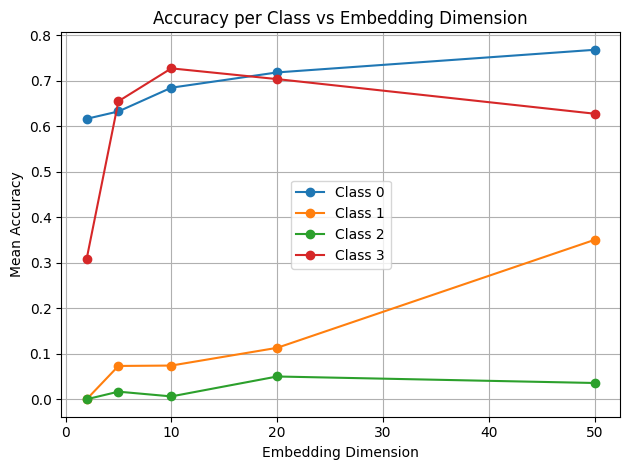

In [98]:
embedding_dims = [2, 5, 10, 20, 50]
results, accs = train_and_evaluate_simple(Aij, embedding_dims, holdout_ratio=0.1, n_epochs=200, lr=0.01)

plot_class_accuracy(embedding_dims, accs)

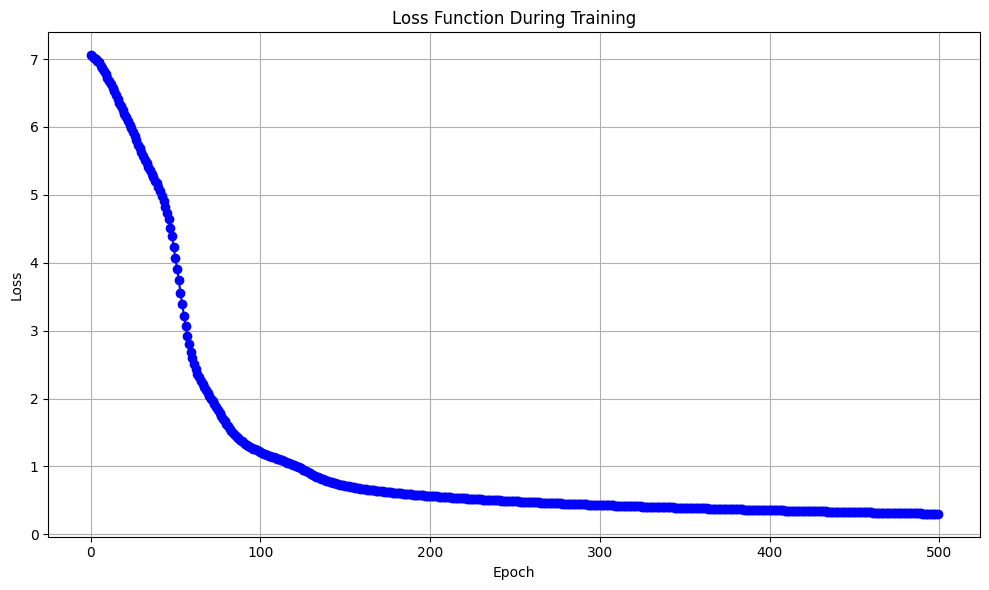

In [111]:
def plot_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(losses)), losses, marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Function During Training')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

model = LDMP(Aij, embedding_dim=17, device=device, n_epochs=500, lr=0.01, seed=20)
losses = model.train()
plot_loss(losses)

In [115]:
Aij_train, holdout_indices = create_holdout(Aij, holdout_ratio=0.1, seed=20)
model = LDMP(Aij_train, embedding_dim=17, device=device, n_epochs=500, lr=0.01, seed=42)
model.train()
predicted_categories, probit_matrix = model.predict_categories()
print("Aij_train:\n", Aij_train, "\nAij_pred:\n", predicted_categories)

Aij_train:
 tensor([[0., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
        [0., 0., 2., 0., 1., 0., 3., 0., 0., 0., 0., 0.],
        [3., 3., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
        [3., 0., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0.],
        [0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0.],
        [1., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
        [0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
        [0., 3., 1., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
        [3., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 0., 2., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]) 
Aij_pred:
 tensor([[0, 1, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
        [0, 0, 2, 0, 1, 0, 3, 0, 0, 0, 0, 0],
        [3, 3, 0, 0, 0, 1, 0, 3, 0, 0, 0, 1],
        [3, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 0],
        [0, 0, 2, 0, 0, 0, 3, 0, 1, 0, 0, 0],
        [1, 2, 0, 3, 1, 2, 0, 0, 2, 0, 1, 0],
        [0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 0],
        [0, 3, 1, 0, 0, 1, 0, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 1, 

In [116]:
def compute_entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log(probs + 1e-10))

In [ ]:
def Mutual_Information(Aij_true, Aij_train):
    joint_counts = np.zeroes((np.max(Aij_true)+1, np.max(Aij_train)+1))

    for true, pred in zip(Aij_true, Aij_train):
        joint_counts[true, pred]+=1

In [122]:
Aij

tensor([[0., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
        [0., 0., 2., 0., 1., 0., 3., 0., 0., 1., 0., 0.],
        [3., 3., 0., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
        [3., 3., 0., 0., 0., 2., 0., 0., 1., 0., 1., 0.],
        [0., 0., 2., 0., 0., 0., 3., 0., 1., 0., 0., 0.],
        [1., 2., 0., 3., 1., 2., 0., 0., 2., 0., 1., 0.],
        [0., 0., 2., 0., 1., 0., 0., 1., 0., 1., 0., 0.],
        [0., 3., 1., 0., 0., 1., 0., 3., 0., 0., 0., 1.],
        [3., 3., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.],
        [0., 0., 2., 1., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [124]:
np.max(Aij)

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis


In [119]:
joint_counts = np.zeros((np.max(Aij)+1, np.max(Aij_train)+1))

for true, pred in zip(Aij, Aij_train):
    joint_counts[true, pred]+=1

TypeError: max() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim = False)
      didn't match because some of the keywords were incorrect: out, axis
